#Notebook: MLP Model in Binary Classification
##Author: Lucía Núñez Calvo
###Date: 28/04/2024

####Summary
This notebook shows two implementations of the Multilayer Perceptron (**MLP**) model.The first implementation tests without cross-validation, while the second implementation tests using cross-validation.

Firstly, tests of the MLP model have been performed using **MFCC** and **LPC** features **without** applying **cross-validation**. In addition, the **AUC** (Area Under the Curve) and the **ROC** curve have been calculated to evaluate the performance of the model.

Secondly, **cross-validation** has been applied to evaluate the MLP model, again using **MFCC** and **LPC** features, and evaluating the results with **AUC** and **ROC** curve.

Subsequently, a comparison of the results obtained from both implementations is performed. For this purpose, **confusion matrices** and graphs reflecting the **Accuracy**, **Recall** and **F1-score** metrics of the different classes have been created. These visualisations allow a detailed comparison of the performance of the model in each approach, providing a clear view of the strengths and weaknesses of each method and helping to determine the best strategy for classification.

Also, a **double validation** is performed using the data that has not been seen with the pre-trained models, specifically using the model with **cross-validation and MFCC features**. In this last phase, for each audio file, a graph representing the probability of crying along the audio file is created.

Finally, a list of dictionaries containing the probabilities that the baby is crying or not in each second of the audio file is created. These results are stored in a file for later use in other projects.





####Structure of the notebook

0.   Load features
1.   MLP without cross-validation
2.   MLP with cross-validation
3.   Checking the results
4.   Double validation
5.   Save the results


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score

## 0. Load features

In [ ]:
features_mfcc = np.load('features_mfcc_binary.npy')
labels_mfcc = np.load('labels_mfcc_binary.npy')

features_lpc = np.load('features_lpc_binary.npy')
labels_lpc = np.load('labels_lpc_binary.npy')

In [ ]:
print("Length of MFCC features:", len(features_mfcc))
print("Length of LPC features:", len(features_lpc))
print("Length of MFCC labels:", len(labels_mfcc))
print("Length of LPC labels:", len(labels_lpc))

Length of MFCC features: 12399
Length of LPC features: 12399
Length of MFCC labels: 12399
Length of LPC labels: 12399


## 1. MLP without cross-validation

In [ ]:
def create_model(features, labels, title):
    '''
    This function creates and trains an MLP model.

    Input:
      - features: (array) Set of input features for the model.
      - labels: (array) Labels corresponding to the input features.
      - title: (str) Title for the graphic.

    Output:
      - model: (MLPClassifier) Trained MLP model.
      - scaler: (object) scaler of the features.
      - y_test: (array) Labels of the test set.
      - y_pred: (array) Labels predicted by the model in the test set.
    '''
    # Division of data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

    # Combination of oversampling and undersampling
    smote_tomek = SMOTETomek(random_state=42)
    X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

    # Scaling the features
    scaler = StandardScaler()
    X_train_resampled = scaler.fit_transform(X_train_resampled)
    X_test = scaler.transform(X_test)

    # Training the model
    model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=800)
    model.fit(X_train_resampled, y_train_resampled)

    # Obtain probabilities and calculate the ROC curve
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    # Best threshold based on the balance between tpr and fpr
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    y_pred = (y_scores >= optimal_threshold).astype(int)

    auc = roc_auc_score(y_test, y_scores)

    # Graph ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

    return model, scaler, y_test, y_pred

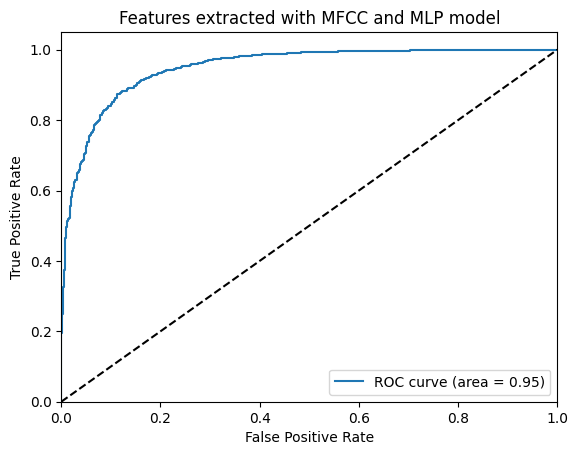

              precision    recall  f1-score   support

           0       0.56      0.89      0.69       583
           1       0.98      0.87      0.92      3137

    accuracy                           0.87      3720
   macro avg       0.77      0.88      0.81      3720
weighted avg       0.91      0.87      0.88      3720



In [ ]:
# Tests with MFCC features
model_mfcc, scaler_mfcc, y_test_mfcc, y_pred_mfcc = create_model(features_mfcc, labels_mfcc, 'Features extracted with MFCC and MLP model')
print(classification_report(y_test_mfcc, y_pred_mfcc))

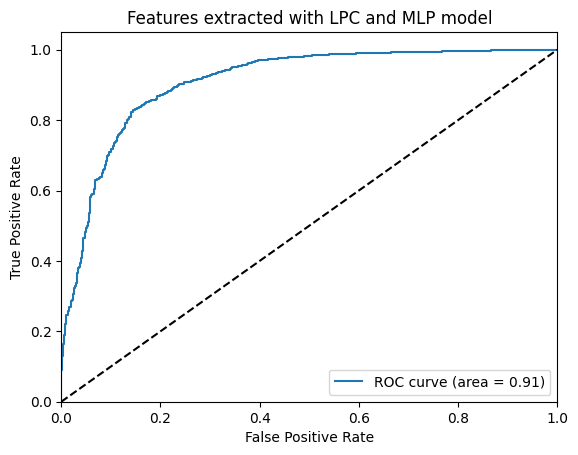

              precision    recall  f1-score   support

           0       0.48      0.86      0.62       583
           1       0.97      0.83      0.89      3137

    accuracy                           0.83      3720
   macro avg       0.72      0.84      0.75      3720
weighted avg       0.89      0.83      0.85      3720



In [ ]:
# Tests with LPC features
model_lpc, scaler_lpc, y_test_lpc, y_pred_lpc = create_model(features_lpc, labels_lpc, 'Features extracted with LPC and MLP model')
print(classification_report(y_test_lpc, y_pred_lpc))

## 2. MLP with cross-validation

In [ ]:
def create_model_with_cross_validation(features, labels, title):
    '''
    This function creates and trains an MLP model whit cross-validation.
    During each iteration of the cross-validation, the actual labels of the test set (y_test) and the labels predicted by the model (y_pred) are accumulated.
    This is done to combine the results of all the folds and get an overall evaluation of the model.

    Input:
      - features: (array) Set of input features for the model.
      - labels: (array) Labels corresponding to the input features.
      - title: (str) Title for the graphic.

    Output:
      - model: (MLPClassifier) Trained MLP model.
      - scaler: (object) scaler of the features.
      - y_test: (array) Labels of the test set.
      - y_pred: (array) Labels predicted by the model in the test set.
    '''
    y_test_accum = []
    y_pred_accum = []
    aucs = []

    # Cross-validation with 5 folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in cv.split(features, labels):

        # Division of data into training and test sets
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Combination of oversampling and undersampling
        smote_tomek = SMOTETomek(random_state=42)
        X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

        # Scaling the features
        scaler = StandardScaler()
        X_train_resampled = scaler.fit_transform(X_train_resampled)
        X_test = scaler.transform(X_test)

        # Training the model
        model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=1400)
        model.fit(X_train_resampled, y_train_resampled)

        # Obtain probabilities and calculate the ROC curve
        y_scores = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)

        # Best threshold based on the balance between tpr and fpr
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        y_pred = (y_scores >= optimal_threshold).astype(int)

        # Accumulate results
        y_test_accum.extend(y_test)
        y_pred_accum.extend(y_pred)

        # Save individual results
        aucs.append(roc_auc_score(y_test, y_scores))

    # AUC average
    auc = np.mean(aucs)

    # Graph ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


    return model, scaler, np.array(y_test_accum), np.array(y_pred_accum)

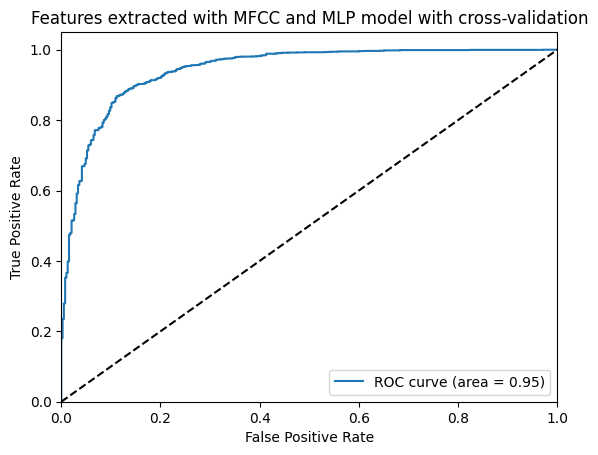

              precision    recall  f1-score   support

           0       0.60      0.88      0.71      1927
           1       0.98      0.89      0.93     10472

    accuracy                           0.89     12399
   macro avg       0.79      0.89      0.82     12399
weighted avg       0.92      0.89      0.90     12399



In [ ]:
# Tests with MFCC features and cross-validation
model_mfcc_cv, scaler_mfcc_cv, y_test_mfcc_cv, y_pred_mfcc_cv = create_model_with_cross_validation(features_mfcc, labels_mfcc, 'Features extracted with MFCC and MLP model with cross-validation')
print(classification_report(y_test_mfcc_cv, y_pred_mfcc_cv))

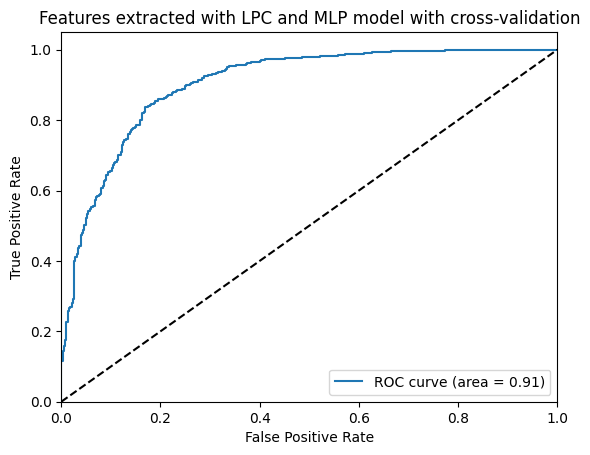

              precision    recall  f1-score   support

           0       0.49      0.82      0.61      1927
           1       0.96      0.84      0.90     10472

    accuracy                           0.84     12399
   macro avg       0.73      0.83      0.76     12399
weighted avg       0.89      0.84      0.85     12399



In [ ]:
# Tests with LPC features and cross-validation
model_lpc_cv, scaler_lpc_cv, y_test_lpc_cv, y_pred_lpc_cv = create_model_with_cross_validation(features_lpc, labels_lpc, 'Features extracted with LPC and MLP model with cross-validation')
print(classification_report(y_test_lpc_cv, y_pred_lpc_cv))

## 3. Checking the results

In [ ]:
# Variables containing the labels the test and the labels predicted by the model in the test set
y_tests = [y_test_mfcc, y_test_mfcc_cv, y_test_lpc, y_test_lpc_cv]
y_preds = [y_pred_mfcc, y_pred_mfcc_cv, y_pred_lpc, y_pred_lpc_cv]

# Variable containing the titles for the representations
titles = ['Features extracted with MFCC\nand MLP model', 'Features extracted with MFCC\nand MLP model with cross-validation',
          'Features extracted with LPC\nand MLP model', 'Features extracted with LPC\nand MLP model with cross-validation']

In [ ]:
def display_confusion_matrices(y_tests, y_preds, titles):
    '''
    Function that displays confusion matrices for multiple models.

    Input:
      - y_tests: (list) List of arrays with the true values (y_test) of each model.
      - y_preds: (list) List of arrays with the predicted values (y_pred) of each model.
      - titles (list) List of titles for each subplot.
    '''
    num_models = len(y_tests)
    fig, axes = plt.subplots(2, 2, figsize=(7, 6))
    axes = axes.flatten()

    for i in range(num_models):
        conf_matrix = confusion_matrix(y_tests[i], y_preds[i])
        sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', ax=axes[i])
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

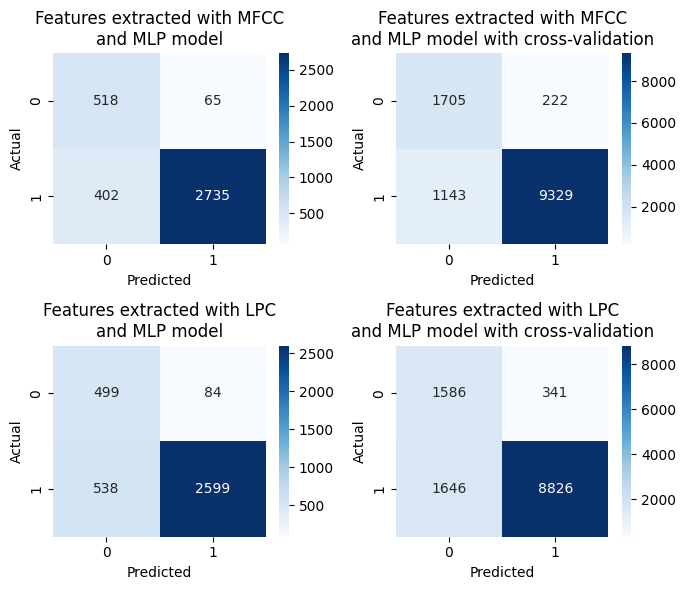

In [ ]:
display_confusion_matrices(y_tests, y_preds, titles)

In [ ]:
titles = ['Features extracted with MFCC and MLP model', 'Features extracted with MFCC and MLP model with cross-validation',
          'Features extracted with LPC and MLP model', 'Features extracted with MLP and MLP model with cross-validation']


def plot_classification_metrics_multiple(y_tests, y_preds, titles):
    '''
    Function that displays the ‘Precision’ ‘Recall’ and ‘F1-score’ for multiple models on a graph.

    Input:
      - y_tests: (list) List of arrays with the true values (y_test) of each model.
      - y_preds: (list) List of arrays with the predicted values (y_pred) of each model.
      - titles (list) List of titles for each subplot.
    '''

    num_models = len(y_tests)
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()

    for i in range(num_models):
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_tests[i], y_preds[i], average=None)
        x = np.arange(len(precision))  # Label locations
        width = 0.3  # Width of the bars

        axes[i].bar(x - width, precision, width, label='Precision', color='darkturquoise')
        axes[i].bar(x, recall, width, label='Recall', color='darksalmon')
        axes[i].bar(x + width, f1_score, width, label='F1 Score', color='darkseagreen')

        axes[i].set_ylabel('Scores')
        axes[i].set_title(titles[i])
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(['Class 0 - Crying baby', 'Class 1 - No crying baby'])
        axes[i].legend()

        # Adding labels on the bars
        def autolabel(rects, ax):
            '''
            Function to add labels on the bars.
            '''
            for rect in rects:
                height = rect.get_height()
                ax.annotate('{}'.format(round(height, 2)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

        rects1 = axes[i].bar(x - width, precision, width, color='darkturquoise')
        rects2 = axes[i].bar(x, recall, width, color='darksalmon')
        rects3 = axes[i].bar(x + width, f1_score, width, color='darkseagreen')

        autolabel(rects1, axes[i])
        autolabel(rects2, axes[i])
        autolabel(rects3, axes[i])

    fig.tight_layout()
    plt.show()

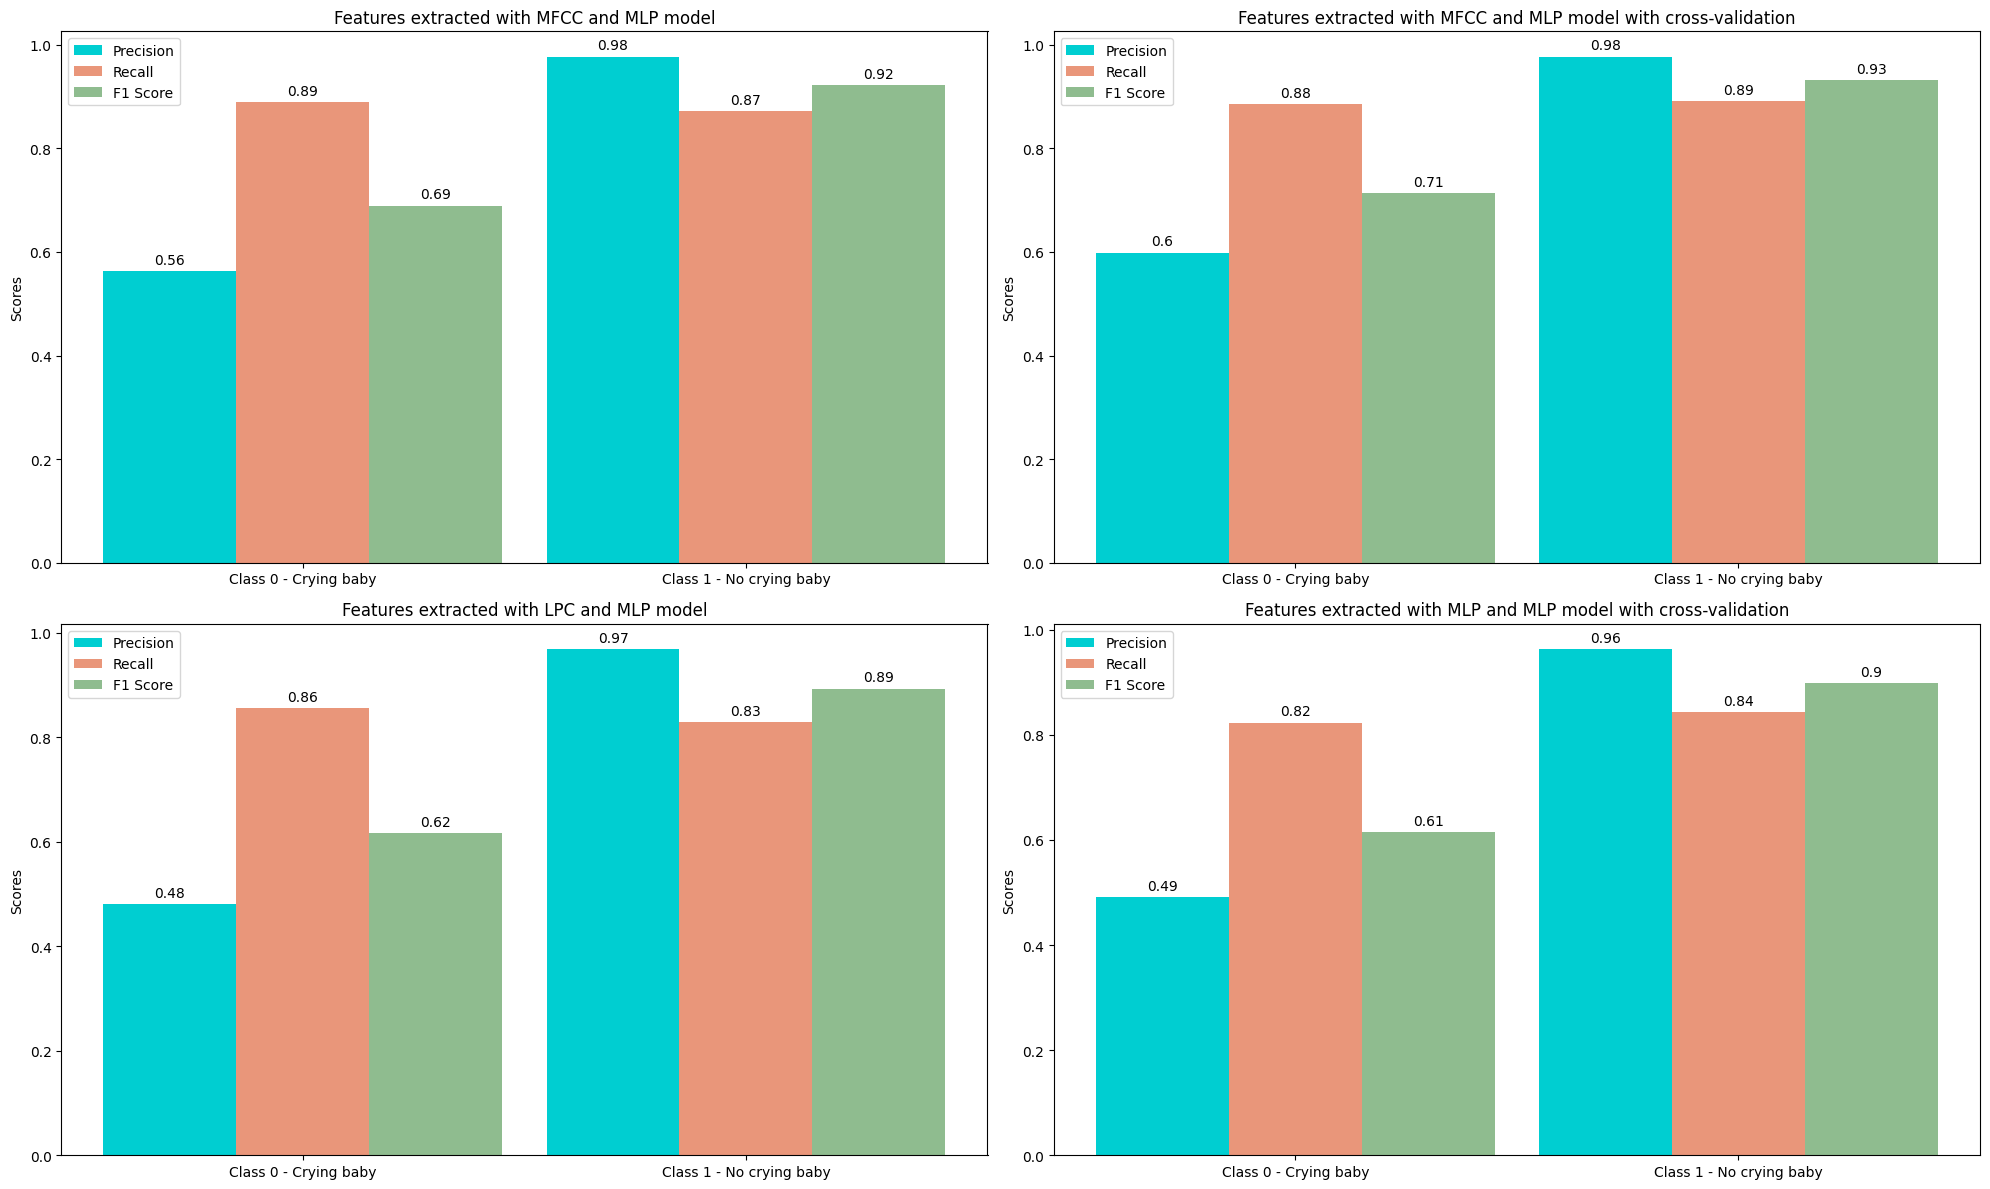

In [ ]:
plot_classification_metrics_multiple(y_tests, y_preds, titles)

##4. Double validation

In [ ]:
def predict_on_new_audio(file_name, model, scaler, n_mfcc=13, sr=44100):
    '''
    Function to predict the probabilities of the ‘cry’ class for a new audio file using a pre-trained model.

    Input:
      - file_name: (str) Path to the audio file.
      - model: (object) Pre-trained model.
      - scaler: (object) To scale features in the same way as the training data.
      - n_mfcc: (int) Number of MFCC coefficients to extract (default: 13).
      - sr: (int) Audio sampling rate (default: 44100 Hz).

    Output:
      - probabilities: (list) List of dictionaries with class probabilities for each segment of the audio.
    '''
    try:
        # Load the audio file and its sample rate
        audio, sample_rate = librosa.load(file_name, sr=sr)
        probabilities = []
        buffer_length = sample_rate

        # Iterate over the audio in 1-second segments
        for i in range(0, len(audio), buffer_length):
            end_i = min(i + buffer_length, len(audio))
            audio_segment = audio[i:end_i]

            # Make sure that the segment is of sufficient length
            if len(audio_segment) < 2048:
                # Apply zero padding at the end if the segment is too short.
                audio_segment = np.pad(audio_segment, (0, 2048 - len(audio_segment)), mode='constant')

            # Calculate the MFCC coefficients for the current segment.
            mfcc = librosa.feature.mfcc(y=audio_segment, sr=sample_rate, n_mfcc=n_mfcc)

            # Scaling the MFCC coefficients as the model has been trained
            mfcc_scaled = np.mean(mfcc.T, axis=0).reshape(1, -1)
            mfcc_scaled = scaler.transform(mfcc_scaled)

             # Obtain probabilities for each class
            proba = model.predict_proba(mfcc_scaled)[0]
            probabilities.append({class_id: prob for class_id, prob in enumerate(proba)})

    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}, Error: {e}")
        return None

    return probabilities

In [ ]:
def plot_probabilities(file_name, probabilities):
    '''
    Function to plot the probabilities of the crying class over time.

    Input:
      - file_name: (str) Name of the audio file.
      - probabilities: (list) List of dictionaries with class probabilities for each segment of the audio.
    '''
    # Extract the probability of class 0 (Baby_cry).
    time_seconds = range(len(probabilities))
    crying_probabilities = [p[0] for p in probabilities if p is not None]

    # Create the graphic
    plt.figure(figsize=(10, 4))
    plt.plot(time_seconds, crying_probabilities, color='palevioletred')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Probability of crying')
    plt.title(f'Probability of crying per second in {file_name}')
    plt.ylim([0, 1])  # Ensures that the Y-axis is 0 to 1
    plt.grid(True)
    plt.show()

Probability for Mild_encephalopathy/ARAHIP1H12082011.wav: [{0: 0.9967913, 1: 0.0032087243}, {0: 0.99892104, 1: 0.0010789529}, {0: 0.00030231476, 1: 0.9996977}, {0: 0.9999681, 1: 3.1872594e-05}, {0: 0.04432994, 1: 0.95567006}, {0: 0.00027042627, 1: 0.9997296}, {0: 0.99997973, 1: 2.0248044e-05}, {0: 0.0018544197, 1: 0.9981456}, {0: 0.36645252, 1: 0.6335475}, {0: 0.2627548, 1: 0.7372452}, {0: 0.1694668, 1: 0.8305332}, {0: 0.99829787, 1: 0.0017021487}, {0: 0.6917182, 1: 0.30828178}, {0: 0.9929671, 1: 0.0070328726}, {0: 0.9570474, 1: 0.042952612}, {0: 0.13476294, 1: 0.86523706}, {0: 0.010082185, 1: 0.9899178}, {0: 0.04589963, 1: 0.9541004}, {0: 0.9356182, 1: 0.06438177}, {0: 0.9885231, 1: 0.011476892}, {0: 0.9932116, 1: 0.0067883725}, {0: 0.0004031062, 1: 0.9995969}, {0: 0.16378713, 1: 0.8362129}, {0: 0.00018113852, 1: 0.99981886}, {0: 0.0018945932, 1: 0.9981054}, {0: 0.00029081106, 1: 0.9997092}, {0: 0.22088349, 1: 0.7791165}, {0: 0.53103644, 1: 0.46896356}, {0: 0.019173384, 1: 0.9808266},

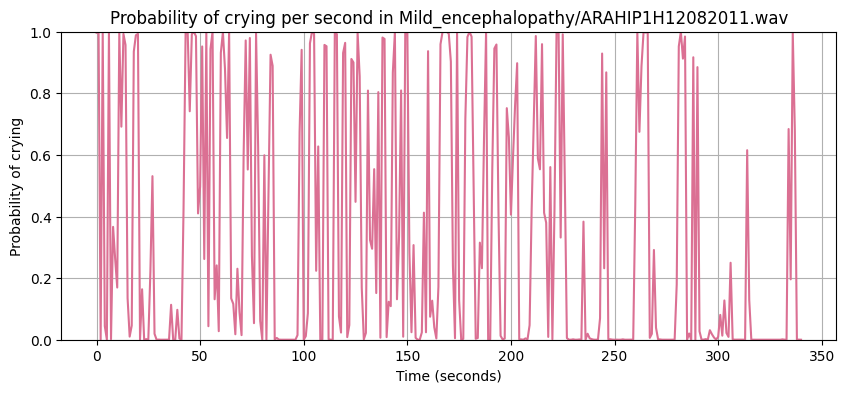

Probability for clips/clip0.wav: [{0: 0.9967913, 1: 0.003208674}, {0: 0.99892104, 1: 0.0010789591}, {0: 0.00030231476, 1: 0.9996977}, {0: 0.9999681, 1: 3.1872263e-05}, {0: 0.04433018, 1: 0.9556698}, {0: 0.00027042627, 1: 0.9997296}, {0: 0.99997973, 1: 2.0247735e-05}, {0: 0.0018544197, 1: 0.9981456}, {0: 0.3664543, 1: 0.6335457}, {0: 0.2627561, 1: 0.7372439}, {0: 0.16946727, 1: 0.8305327}, {0: 0.99829787, 1: 0.0017021446}, {0: 0.69171834, 1: 0.30828163}, {0: 0.9929672, 1: 0.007032823}, {0: 0.95704746, 1: 0.04295254}, {0: 0.13476294, 1: 0.86523706}, {0: 0.010082185, 1: 0.9899178}, {0: 0.04589951, 1: 0.9541005}, {0: 0.9356185, 1: 0.06438148}, {0: 0.9885232, 1: 0.011476801}, {0: 0.9932117, 1: 0.0067883115}, {0: 0.0004031062, 1: 0.9995969}, {0: 0.16378933, 1: 0.83621067}, {0: 0.00018113852, 1: 0.99981886}, {0: 0.0018945932, 1: 0.9981054}, {0: 0.00029081106, 1: 0.9997092}, {0: 0.22088486, 1: 0.77911514}, {0: 0.53103626, 1: 0.46896377}, {0: 0.019173145, 1: 0.98082685}, {0: 2.0742416e-05, 1: 0

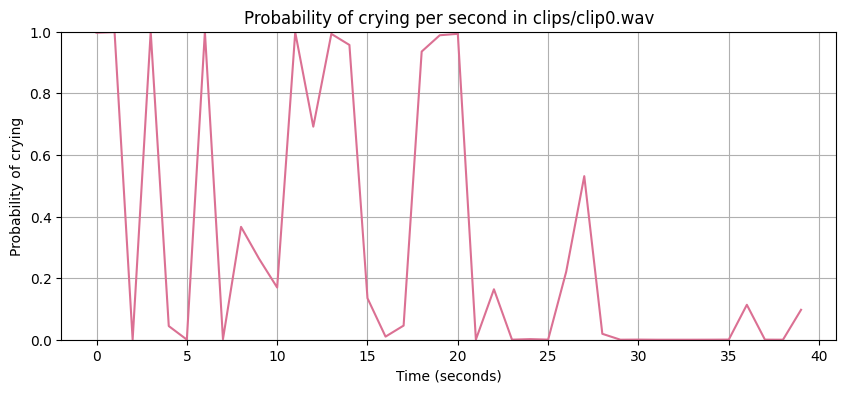

Probability for clips/clip1.wav: [{0: 6.580353e-05, 1: 0.9999342}, {0: 0.42374045, 1: 0.57625955}, {0: 0.9999073, 1: 9.2700044e-05}, {0: 0.99821997, 1: 0.0017800074}, {0: 0.74170303, 1: 0.258297}, {0: 0.9920116, 1: 0.007988388}, {0: 0.99996996, 1: 3.0026113e-05}, {0: 0.9853421, 1: 0.014657923}, {0: 0.41007024, 1: 0.58992976}, {0: 0.496929, 1: 0.503071}, {0: 0.9521639, 1: 0.047836132}, {0: 0.26205134, 1: 0.73794866}, {0: 0.99778605, 1: 0.0022139563}]


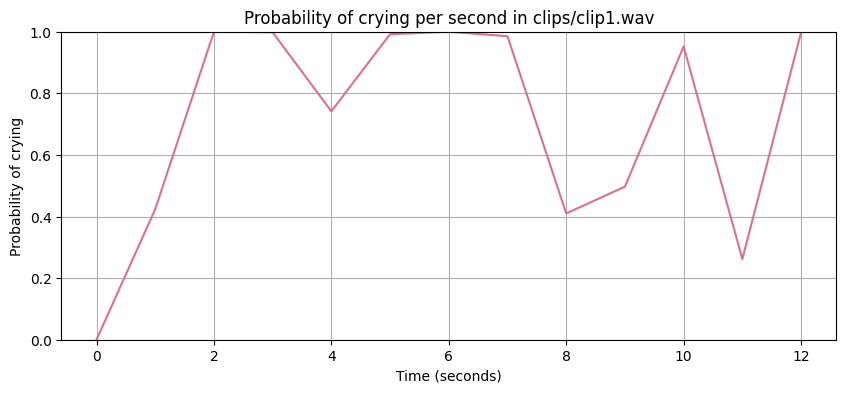

Probability for clips/clip2.wav: [{0: 0.9456483, 1: 0.054351714}, {0: 0.99998915, 1: 1.0852557e-05}, {0: 0.1313327, 1: 0.8686673}, {0: 0.2413789, 1: 0.7586211}, {0: 0.027689397, 1: 0.9723106}, {0: 0.93141603, 1: 0.06858397}, {0: 0.999011, 1: 0.0009890368}, {0: 0.87968886, 1: 0.120311156}, {0: 0.6550046, 1: 0.34499538}, {0: 0.99987245, 1: 0.00012754324}, {0: 0.13417321, 1: 0.8658268}, {0: 0.11633146, 1: 0.88366854}, {0: 0.017713606, 1: 0.9822864}, {0: 0.23048097, 1: 0.76951903}, {0: 0.09013665, 1: 0.90986335}, {0: 0.014870048, 1: 0.98512995}, {0: 0.60202485, 1: 0.39797515}, {0: 0.9717133, 1: 0.028286701}, {0: 0.5524291, 1: 0.4475709}]


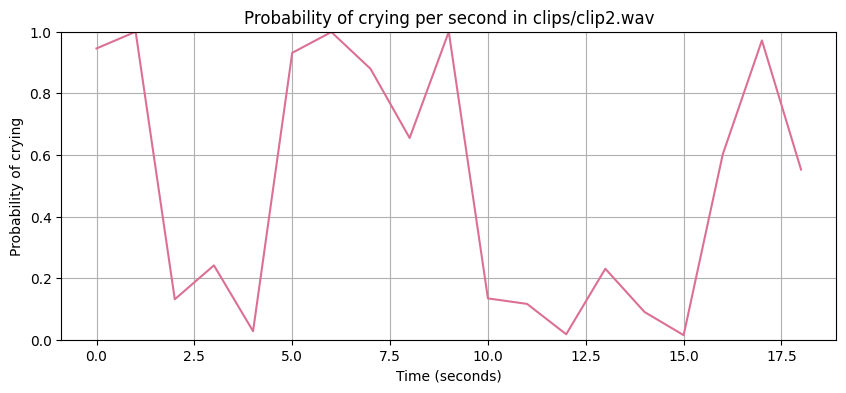

Probability for clips/clip3.wav: [{0: 0.27446938, 1: 0.7255306}, {0: 0.053732336, 1: 0.94626766}, {0: 0.99465907, 1: 0.0053409603}, {0: 0.6254084, 1: 0.37459156}, {0: 0.060853362, 1: 0.93914664}, {0: 6.353855e-05, 1: 0.99993646}, {0: 0.5989423, 1: 0.40105772}, {0: 0.00017291307, 1: 0.9998271}, {0: 0.4777578, 1: 0.5222422}, {0: 0.9253123, 1: 0.07468775}, {0: 0.88913715, 1: 0.11086283}, {0: 0.0004338622, 1: 0.99956614}, {0: 0.0058113337, 1: 0.99418867}, {0: 0.00043672323, 1: 0.9995633}, {0: 2.8133392e-05, 1: 0.99997187}, {0: 5.6505203e-05, 1: 0.9999435}, {0: 1.6331673e-05, 1: 0.99998367}, {0: 0.0001565218, 1: 0.9998435}, {0: 2.6583672e-05, 1: 0.9999734}, {0: 9.536743e-06, 1: 0.99999046}, {0: 1.9073486e-06, 1: 0.9999981}]


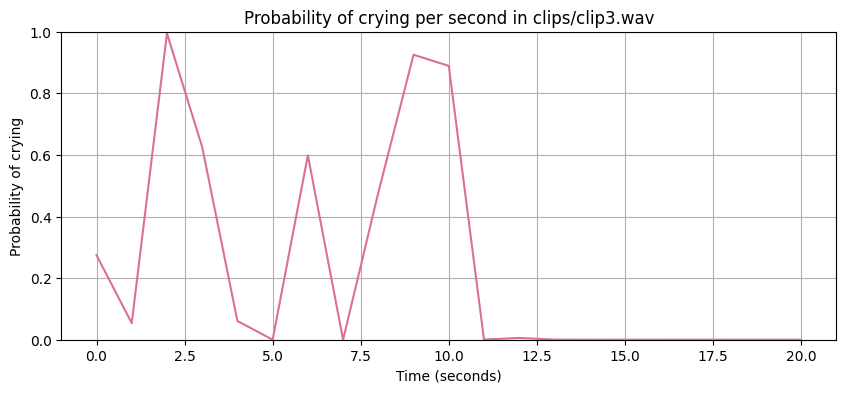

Probability for clips/clip4.wav: [{0: 0.015153885, 1: 0.9848461}, {0: 0.6740669, 1: 0.32593307}, {0: 0.94128317, 1: 0.05871682}, {0: 0.0002078414, 1: 0.99979216}, {0: 0.011521399, 1: 0.9884786}, {0: 0.086244226, 1: 0.9137558}, {0: 0.96242875, 1: 0.03757123}, {0: 0.99958116, 1: 0.00041884734}, {0: 0.99314046, 1: 0.00685957}, {0: 0.22385073, 1: 0.7761493}, {0: 0.6274888, 1: 0.3725112}, {0: 6.914139e-05, 1: 0.99993086}, {0: 0.00045484304, 1: 0.99954516}, {0: 0.95716757, 1: 0.042832427}, {0: 0.9528006, 1: 0.047199454}, {0: 0.0014105439, 1: 0.99858946}, {0: 2.4199486e-05, 1: 0.9999758}, {0: 5.2452087e-06, 1: 0.99999475}, {0: 0.9980322, 1: 0.0019677859}, {0: 0.9923263, 1: 0.007673692}, {0: 0.07542217, 1: 0.92457783}, {0: 0.023258686, 1: 0.9767413}, {0: 0.9309635, 1: 0.069036506}, {0: 0.9638702, 1: 0.03612978}, {0: 0.008396685, 1: 0.9916033}, {0: 0.0476923, 1: 0.9523077}, {0: 0.9114755, 1: 0.088524535}, {0: 0.90020823, 1: 0.09979177}, {0: 0.44671363, 1: 0.5532864}]


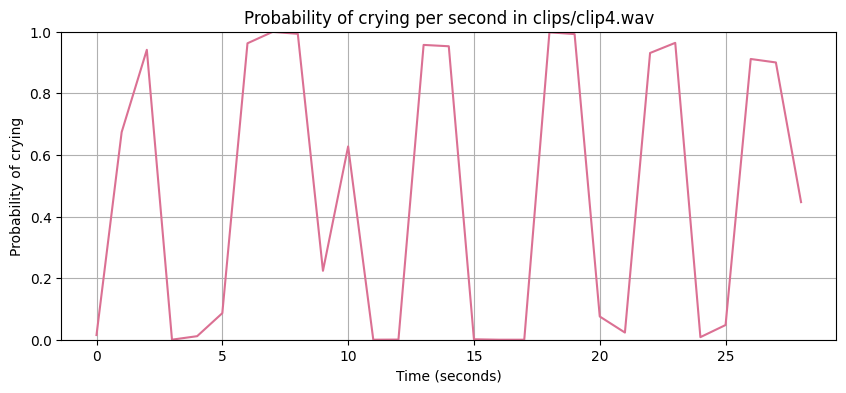

Probability for clips/clip5.wav: [{0: 0.8553219, 1: 0.14467815}, {0: 0.16912204, 1: 0.83087796}, {0: 0.0011082292, 1: 0.9988918}, {0: 0.021967292, 1: 0.9780327}, {0: 0.80900115, 1: 0.19099884}, {0: 0.32379645, 1: 0.67620355}, {0: 0.29538554, 1: 0.70461446}, {0: 0.5537467, 1: 0.4462533}, {0: 0.15154994, 1: 0.84845006}, {0: 0.80386287, 1: 0.19613713}, {0: 0.0064667463, 1: 0.99353325}, {0: 0.98113954, 1: 0.01886046}, {0: 0.9765987, 1: 0.023401324}, {0: 0.0084037185, 1: 0.9915963}, {0: 0.12328392, 1: 0.8767161}, {0: 0.108923554, 1: 0.89107645}, {0: 0.8679615, 1: 0.1320385}, {0: 0.9993381, 1: 0.00066191977}, {0: 0.13137454, 1: 0.86862546}, {0: 0.33371228, 1: 0.6662877}, {0: 0.80934685, 1: 0.19065316}, {0: 0.009731948, 1: 0.99026805}, {0: 0.9974715, 1: 0.0025284751}, {0: 0.9999845, 1: 1.5520996e-05}, {0: 0.28312582, 1: 0.7168742}, {0: 0.024387836, 1: 0.97561216}, {0: 0.30725402, 1: 0.692746}, {0: 0.006166339, 1: 0.99383366}, {0: 5.6147575e-05, 1: 0.99994385}]


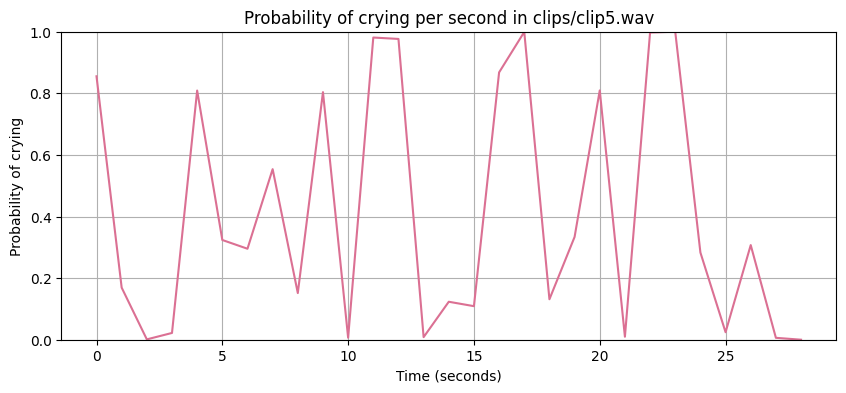

Probability for clips/clip6.wav: [{0: 0.025001287, 1: 0.9749987}, {0: 0.41250086, 1: 0.58749914}, {0: 0.024144411, 1: 0.9758556}, {0: 0.9368404, 1: 0.063159585}, {0: 0.07466918, 1: 0.9253308}, {0: 0.12674981, 1: 0.8732502}, {0: 0.04036987, 1: 0.95963013}, {0: 0.0040543675, 1: 0.99594563}, {0: 0.17183125, 1: 0.82816875}, {0: 0.9593631, 1: 0.040636886}, {0: 0.9998968, 1: 0.00010317028}, {0: 0.99991745, 1: 8.256248e-05}, {0: 0.99973077, 1: 0.00026923724}, {0: 0.99373066, 1: 0.0062693562}, {0: 0.90315074, 1: 0.09684924}, {0: 0.24137563, 1: 0.7586244}, {0: 0.0048121214, 1: 0.9951879}, {0: 0.99988055, 1: 0.000119461}, {0: 0.1279388, 1: 0.8720612}, {0: 1.5854836e-05, 1: 0.99998415}, {0: 0.0030267239, 1: 0.9969733}, {0: 0.7180896, 1: 0.28191042}, {0: 0.9830851, 1: 0.016914897}, {0: 0.99974406, 1: 0.00025593882}, {0: 0.9842116, 1: 0.015788369}, {0: 0.48911238, 1: 0.5108876}, {0: 0.0031787157, 1: 0.9968213}, {0: 0.005604863, 1: 0.99439514}, {0: 0.31519645, 1: 0.68480355}, {0: 0.23210466, 1: 0.76

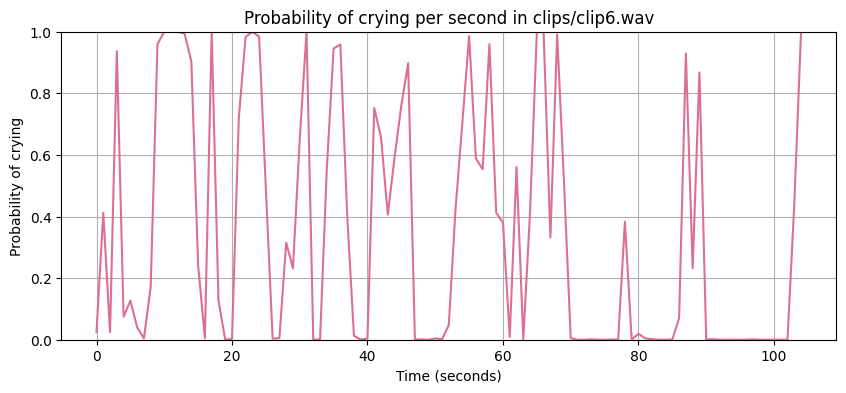

Probability for clips/clip7.wav: [{0: 0.8879684, 1: 0.11203159}, {0: 0.99967474, 1: 0.000325242}, {0: 0.99748576, 1: 0.0025142685}, {0: 0.99890417, 1: 0.001095808}, {0: 0.006021142, 1: 0.99397886}, {0: 0.01917094, 1: 0.98082906}, {0: 0.29140782, 1: 0.7085922}, {0: 0.039053798, 1: 0.9609462}, {0: 0.0016329885, 1: 0.998367}, {0: 0.00090265274, 1: 0.99909735}, {0: 9.7990036e-05, 1: 0.999902}, {0: 3.5762787e-07, 1: 0.99999964}, {0: 1.1920929e-06, 1: 0.9999988}, {0: 0.0, 1: 1.0}, {0: 8.225441e-06, 1: 0.9999918}, {0: 2.6464462e-05, 1: 0.99997354}, {0: 0.00023263693, 1: 0.99976736}, {0: 0.17932028, 1: 0.8206797}, {0: 0.95241684, 1: 0.04758318}, {0: 0.9999999, 1: 1.4825062e-07}, {0: 0.91265106, 1: 0.08734891}, {0: 0.9843903, 1: 0.0156096965}, {0: 0.00015902519, 1: 0.999841}, {0: 0.020295382, 1: 0.9797046}, {0: 7.1525574e-07, 1: 0.9999993}, {0: 0.91700816, 1: 0.08299182}, {0: 6.67572e-06, 1: 0.9999933}, {0: 0.88499594, 1: 0.11500404}, {0: 0.027382255, 1: 0.97261775}, {0: 5.3286552e-05, 1: 0.999

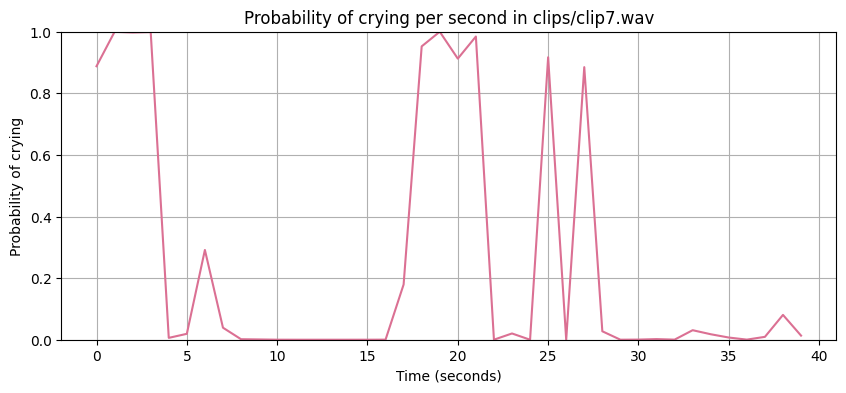

Probability for clips/clip8.wav: [{0: 0.021940172, 1: 0.9780598}, {0: 0.009159863, 1: 0.99084014}, {0: 0.24988955, 1: 0.75011045}, {0: 0.0009797812, 1: 0.9990202}, {0: 0.00015377998, 1: 0.9998462}, {0: 3.6239624e-05, 1: 0.99996376}, {0: 0.00026482344, 1: 0.9997352}, {0: 0.00019961596, 1: 0.9998004}, {0: 8.845329e-05, 1: 0.99991155}, {0: 2.7775764e-05, 1: 0.9999722}, {0: 0.61534023, 1: 0.38465977}, {0: 0.12896597, 1: 0.871034}, {0: 0.00015449524, 1: 0.9998455}, {0: 5.4836273e-06, 1: 0.9999945}, {0: 2.3841858e-07, 1: 0.99999976}, {0: 1.3947487e-05, 1: 0.99998605}, {0: 0.0001398325, 1: 0.99986017}, {0: 2.7418137e-05, 1: 0.9999726}, {0: 1.0251999e-05, 1: 0.99998975}, {0: 0.0003027916, 1: 0.9996972}, {0: 9.536743e-07, 1: 0.99999905}, {0: 5.841255e-06, 1: 0.99999416}, {0: 1.1920929e-07, 1: 0.9999999}, {0: 3.2186508e-06, 1: 0.9999968}, {0: 0.0, 1: 1.0}, {0: 1.1920929e-06, 1: 0.9999988}, {0: 1.1920929e-07, 1: 0.9999999}, {0: 0.0011945963, 1: 0.9988054}, {0: 0.000251472, 1: 0.9997485}, {0: 2.62

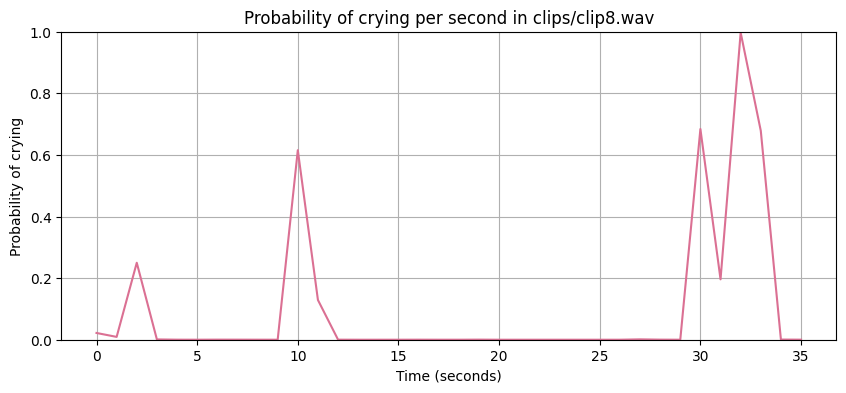

Probability for Moderate_encephalopathy/let.wav: [{0: 4.2915344e-06, 1: 0.9999957}, {0: 3.4570694e-06, 1: 0.99999654}, {0: 3.33786e-06, 1: 0.99999666}, {0: 1.5735626e-05, 1: 0.99998426}, {0: 2.7418137e-06, 1: 0.99999726}, {0: 1.7404556e-05, 1: 0.9999826}, {0: 0.0001937747, 1: 0.9998062}, {0: 2.3841858e-06, 1: 0.9999976}, {0: 1.7523766e-05, 1: 0.9999825}, {0: 4.6491623e-06, 1: 0.99999535}, {0: 6.425381e-05, 1: 0.99993575}, {0: 4.4941902e-05, 1: 0.99995506}, {0: 1.5497208e-05, 1: 0.9999845}, {0: 1.347065e-05, 1: 0.9999865}, {0: 1.8715858e-05, 1: 0.9999813}, {0: 3.5762787e-05, 1: 0.99996424}, {0: 0.0034193397, 1: 0.99658066}, {0: 0.00023549795, 1: 0.9997645}, {0: 1.3589859e-05, 1: 0.9999864}, {0: 1.7046928e-05, 1: 0.99998295}, {0: 3.3974648e-05, 1: 0.999966}, {0: 1.0251999e-05, 1: 0.99998975}, {0: 1.4305115e-05, 1: 0.9999857}, {0: 4.7683716e-06, 1: 0.99999523}, {0: 1.013279e-05, 1: 0.99998987}, {0: 1.001358e-05, 1: 0.99999}, {0: 8.46386e-06, 1: 0.99999154}, {0: 1.0728836e-06, 1: 0.9999989

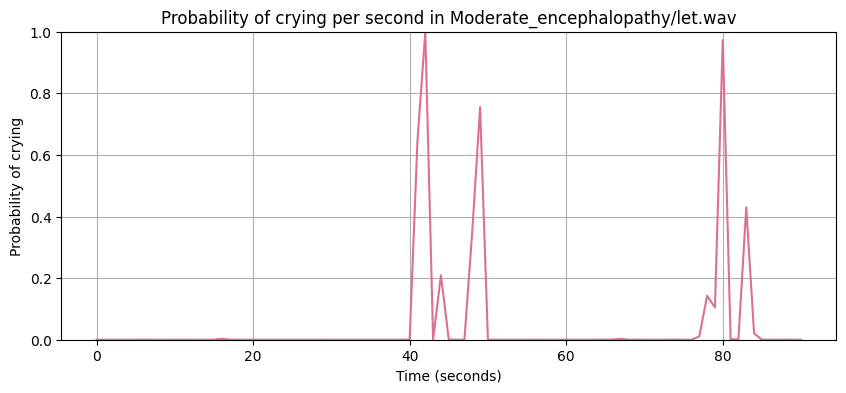

Probability for Severe_encephalopathy/ARAHIP_08062011_1hora.wav: [{0: 0.00043016672, 1: 0.99956983}, {0: 0.0032238364, 1: 0.99677616}, {0: 2.670288e-05, 1: 0.9999733}, {0: 2.861023e-06, 1: 0.99999714}, {0: 0.008004308, 1: 0.9919957}, {0: 3.7908554e-05, 1: 0.9999621}, {0: 1.847744e-05, 1: 0.9999815}, {0: 0.00082308054, 1: 0.9991769}, {0: 0.0077813864, 1: 0.9922186}, {0: 0.004820466, 1: 0.99517953}, {0: 0.004996836, 1: 0.99500316}, {0: 7.402897e-05, 1: 0.999926}, {0: 0.00011610985, 1: 0.9998839}, {0: 0.00028795004, 1: 0.99971205}, {0: 1.2397766e-05, 1: 0.9999876}, {0: 5.686283e-05, 1: 0.99994314}, {0: 0.0016741157, 1: 0.9983259}, {0: 8.356571e-05, 1: 0.99991643}, {0: 0.0002349019, 1: 0.9997651}, {0: 0.00058591366, 1: 0.9994141}, {0: 0.0016499758, 1: 0.99835}, {0: 4.7802925e-05, 1: 0.9999522}, {0: 0.00017601252, 1: 0.999824}, {0: 0.00559777, 1: 0.9944022}, {0: 0.0007211566, 1: 0.99927884}, {0: 8.46386e-06, 1: 0.99999154}, {0: 0.0046607256, 1: 0.9953393}, {0: 0.0010195374, 1: 0.99898046}, 

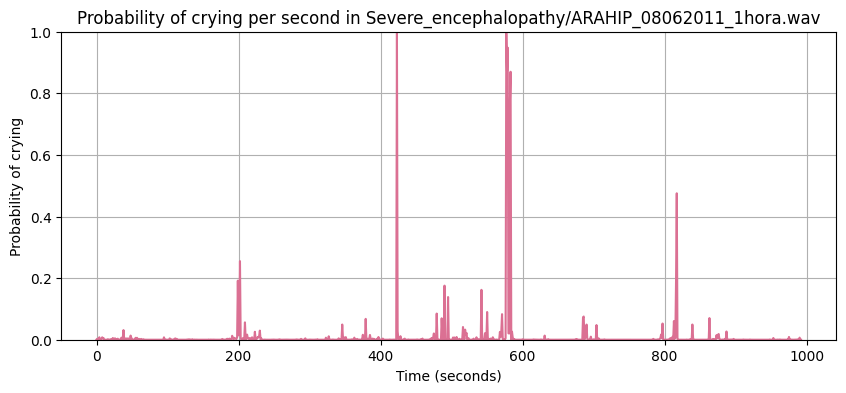

Probability for No_encephalopathy/no_let2.wav: [{0: 0.000502944, 1: 0.99949706}, {0: 0.0011857748, 1: 0.9988142}, {0: 4.339218e-05, 1: 0.9999566}, {0: 0.0013049245, 1: 0.9986951}, {0: 0.082001686, 1: 0.9179983}, {0: 0.10100466, 1: 0.89899534}, {0: 0.2805186, 1: 0.7194814}, {0: 0.22933239, 1: 0.7706676}, {0: 0.17203397, 1: 0.82796603}, {0: 0.040385425, 1: 0.9596146}, {0: 0.480775, 1: 0.519225}, {0: 0.14734137, 1: 0.8526586}, {0: 0.17432785, 1: 0.82567215}, {0: 0.39003032, 1: 0.6099697}, {0: 0.017762125, 1: 0.9822379}, {0: 0.06887537, 1: 0.9311246}, {0: 0.008259892, 1: 0.9917401}, {0: 0.030392706, 1: 0.9696073}, {0: 0.74416316, 1: 0.25583687}, {0: 0.24267137, 1: 0.7573286}, {0: 0.04317808, 1: 0.9568219}, {0: 0.32526404, 1: 0.67473596}, {0: 0.74933773, 1: 0.25066227}, {0: 0.9999988, 1: 1.2153761e-06}, {0: 0.79287696, 1: 0.20712301}, {0: 0.9999918, 1: 8.225177e-06}, {0: 0.9999785, 1: 2.1498967e-05}, {0: 0.9999975, 1: 2.5049276e-06}, {0: 1.0, 1: 2.2832074e-10}, {0: 1.0, 1: 2.5547532e-08}, {

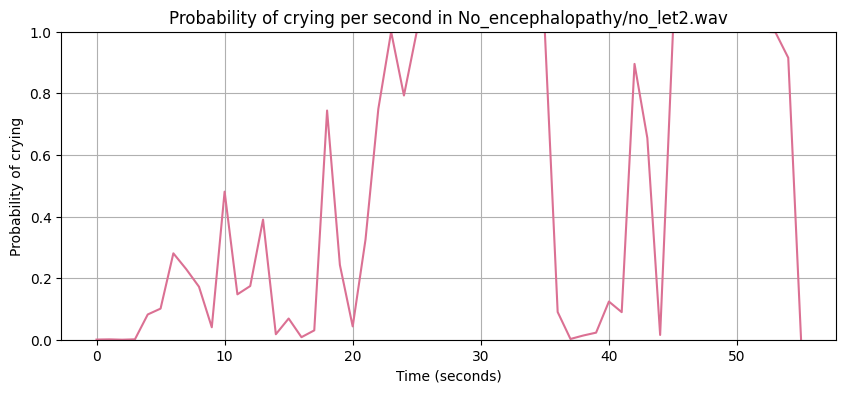

Probability for No_encephalopathy/no_let.wav: [{0: 1.04904175e-05, 1: 0.9999895}, {0: 0.040305614, 1: 0.9596944}, {0: 0.018717289, 1: 0.9812827}, {0: 0.00024217367, 1: 0.9997578}, {0: 0.0008481741, 1: 0.9991518}, {0: 0.000101685524, 1: 0.9998983}, {0: 0.00154531, 1: 0.9984547}, {0: 0.00017553568, 1: 0.99982446}, {0: 0.0013412237, 1: 0.9986588}, {0: 0.00014090538, 1: 0.9998591}, {0: 1.859665e-05, 1: 0.9999814}, {0: 0.00017851591, 1: 0.9998215}, {0: 0.0009391904, 1: 0.9990608}, {0: 0.028567076, 1: 0.9714329}, {0: 0.0009378791, 1: 0.9990621}, {0: 0.0009304881, 1: 0.9990695}, {0: 0.0010943413, 1: 0.99890566}, {0: 0.000613451, 1: 0.99938655}, {0: 8.714199e-05, 1: 0.99991286}, {0: 0.00021976233, 1: 0.99978024}, {0: 0.00281775, 1: 0.99718225}, {0: 1.9907951e-05, 1: 0.9999801}, {0: 0.008136392, 1: 0.9918636}, {0: 0.00058496, 1: 0.99941504}, {0: 0.00014269352, 1: 0.9998573}, {0: 9.429455e-05, 1: 0.9999057}, {0: 0.0002745986, 1: 0.9997254}, {0: 1.2636185e-05, 1: 0.99998736}, {0: 3.2305717e-05, 1

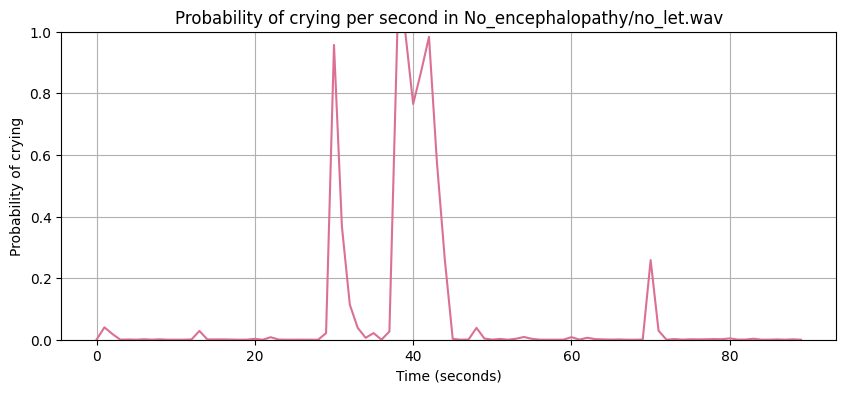

In [ ]:
base_path = "drive/MyDrive/TFM/Audios/"

# List of audio files to perform double validation.
new_audio_files = [
    "Mild_encephalopathy/ARAHIP1H12082011.wav",
    "Mild_encephalopathy/clips/clip0.wav",
    "Mild_encephalopathy/clips/clip1.wav",
    "Mild_encephalopathy/clips/clip2.wav",
    "Mild_encephalopathy/clips/clip3.wav",
    "Mild_encephalopathy/clips/clip4.wav",
    "Mild_encephalopathy/clips/clip5.wav",
    "Mild_encephalopathy/clips/clip6.wav",
    "Mild_encephalopathy/clips/clip7.wav",
    "Mild_encephalopathy/clips/clip8.wav",
    "Moderate_encephalopathy/let.wav",
    "Severe_encephalopathy/ARAHIP_08062011_1hora.wav",
    "No_encephalopathy/no_let2.wav",
    "No_encephalopathy/no_let.wav"
]

# Make predictions on new audios and plot the results
for relative_path in new_audio_files:

    full_path = os.path.join(base_path, relative_path)
    path_parts = relative_path.split('/')
    file_name = os.path.join(path_parts[-2], path_parts[-1])

    # Extract and graph the probabilities of the baby crying
    probabilities = predict_on_new_audio(full_path, model_mfcc_cv, scaler_mfcc_cv)
    print(f"Probability for {file_name}: {probabilities}")
    plot_probabilities(file_name, probabilities)

## 5. Save the results

In [ ]:
# Directory where the folders containing the audio files are located.
audio_base_path = "drive/MyDrive/TFM/Audios"

# DataFrame to store the results
probabilities_with_MLP = pd.DataFrame(columns=["File_Path", "Probabilities"])

# Browse all subfolders and files
for root, dirs, files in os.walk(audio_base_path):
    for file in files:

        # Process only audio files with .wav extension
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            # The probabilities are extracted as in the previous step.
            probabilities = predict_on_new_audio(file_path, model_mfcc_cv, scaler_mfcc_cv)

            if probabilities is not None:
                new_row = pd.DataFrame({"File_Path": [file], "Probabilities": [probabilities]})
                probabilities_with_MLP = pd.concat([probabilities_with_MLP, new_row], ignore_index=True)
            else:
                print(f"Failed to process {file_path}")

# Saving the DataFrame in a CSV file
csv_path = os.path.join(audio_base_path, "probabilities_with_MLP.csv")
probabilities_with_MLP.to_csv(csv_path, index=False)

print(f"Results saved to {csv_path}")

Results saved to drive/MyDrive/TFM/Audios/probabilities_with_MLP.csv


In [ ]:
probabilities_with_MLP

,File_Path,Probabilities
0,39ae6684-c030-4008-ba0c-05551075d2bb.wav,"[{0: 0.004313946, 1: 0.99568605}, {0: 0.424458..."
1,47f38257-5a56-4814-b569-54d1c217719e.wav,"[{0: 0.008859336, 1: 0.99114066}, {0: 0.084338..."
2,0c84b92c-9996-4970-bece-10680196d8d9.wav,"[{0: 0.00021713972, 1: 0.99978286}, {0: 3.7074..."
3,0887b999-d13d-4234-b8ef-c28e93977198.wav,"[{0: 0.9964699, 1: 0.0035300679}, {0: 0.015663..."
4,1181fa2b-8916-45d7-8009-ab2784701b54.wav,"[{0: 0.022033453, 1: 0.97796655}, {0: 0.042677..."
...,...,...
67,clip6.wav,"[{0: 0.015789151, 1: 0.98421085}, {0: 0.983850..."
68,ARAHIP_08062011_1hora.wav,"[{0: 0.0009777546, 1: 0.99902225}, {0: 0.00209..."
69,let.wav,"[{0: 7.1525574e-07, 1: 0.9999993}, {0: 3.57627..."
70,no_let.wav,"[{0: 1.2397766e-05, 1: 0.9999876}, {0: 0.03492..."
